In [16]:
#-- Import Modules
import os
import glob
import rasterio
import numpy as np
import imageio
import matplotlib.pyplot as plt
from scipy.spatial.ckdtree import cKDTree
import scipy.ndimage as ndimage
from skimage.graph import route_through_array
from skimage.morphology import binary_dilation, thin
from skimage import filters, feature, measure
from skimage.morphology import skeletonize
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed, find_boundaries
from centerline.geometry import Centerline
from shapely.geometry import Polygon

In [2]:
#-- directory setup
gdrive = os.path.expanduser('~/Google Drive File Stream/My Drive/')
indir = os.path.join(gdrive,'GL_Learning')
outdir = os.path.expanduser('~/GL_learning_data/geocoded_v1')

In [3]:
#-- get list of files
subdir = 'atrous_32init_drop0.2_customLossR727.dir'
# fileList = glob.glob(os.path.join(indir,'Train_predictions.dir',subdir,'pred*.png'))
fileList = glob.glob(os.path.join(indir,'Test_predictions.dir',subdir,'pred*.png'))
fileList[:5]

['/Users/yaramohajerani/Google Drive File Stream/My Drive/GL_Learning/Test_predictions.dir/atrous_32init_drop0.2_customLossR727.dir/pred_gl_069_180907-180913-180919-180925_023591-012695-023766-012870_T110656_T110656_x1366_y1536_DIR01.png',
 '/Users/yaramohajerani/Google Drive File Stream/My Drive/GL_Learning/Test_predictions.dir/atrous_32init_drop0.2_customLossR727.dir/pred_gl_069_180901-180907-180913-180919_012520-023591-012695-023766_T110455_T110456_x2048_y0512_DIR11.png',
 '/Users/yaramohajerani/Google Drive File Stream/My Drive/GL_Learning/Test_predictions.dir/atrous_32init_drop0.2_customLossR727.dir/pred_gl_069_181206-181212-181218-181224_013920-024991-014095-025166_T110549_T110549_x1536_y2048_DIR11.png',
 '/Users/yaramohajerani/Google Drive File Stream/My Drive/GL_Learning/Test_predictions.dir/atrous_32init_drop0.2_customLossR727.dir/pred_gl_069_181206-181212-181212-181218_013920-024991-024991-014095_T110456_T110537_x1536_y0000_DIR11.png',
 '/Users/yaramohajerani/Google Drive Fil

In [4]:
#-- make corresponding output folder
# out_subdir = os.path.join(outdir,'Train_predictions.dir',subdir)
out_subdir = os.path.join(outdir,'Test_predictions.dir',subdir)
if (not os.path.isdir(out_subdir)):
    os.mkdir(out_subdir)

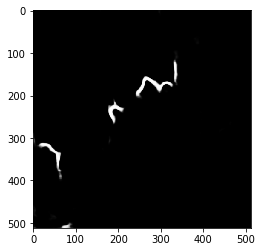

In [5]:
#-- Read an image to test
f = fileList[15]  #[20]
im = imageio.imread(f).astype(float)/255.
plt.imshow(im, cmap=plt.cm.gray)
plt.show()

In [6]:
print(im.max(),im.min())
print(np.count_nonzero(im > 0.5))
print(np.count_nonzero(im < 0.5))

1.0 0.0
2761
259383


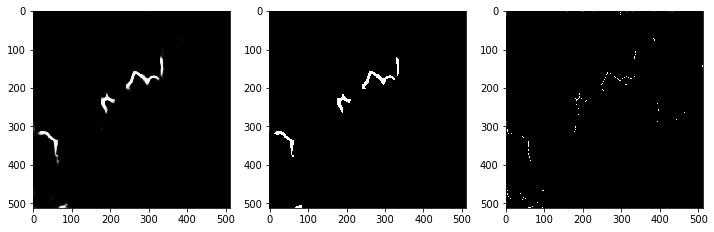

In [7]:
im2 = im.copy()
#-- threshold iamge
ii = np.where(im < 0.5)
jj = np.where(im >= 0.5)
im2[ii] = 0.
im2[jj] = 1.
fig,ax = plt.subplots(1, 3,figsize=(12,6))
ax[0].imshow(im, cmap=plt.cm.gray)
ax[1].imshow(im2, cmap=plt.cm.gray)
ax[2].imshow(thin(im), cmap=plt.cm.gray)
plt.show()

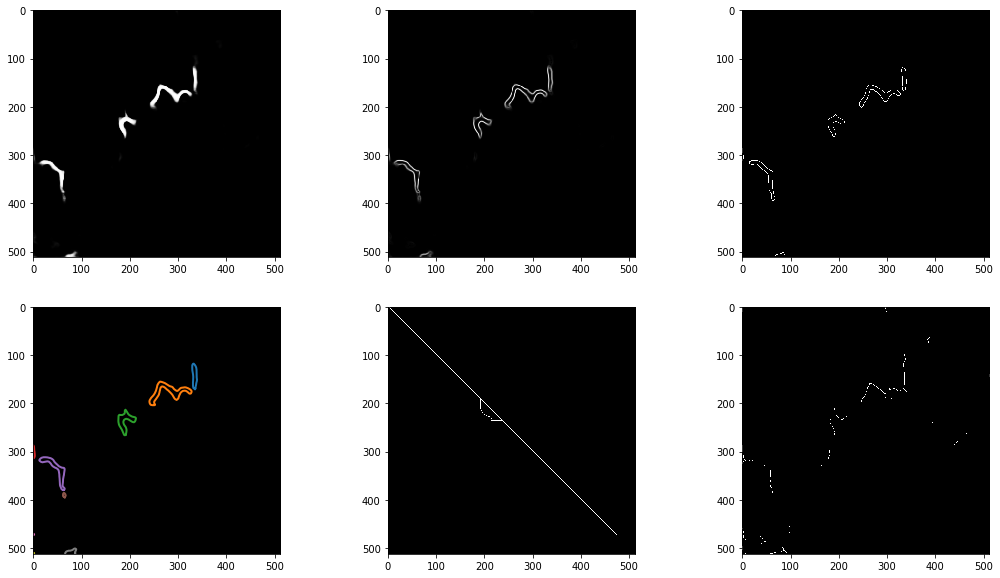

In [8]:
edge_sobel = filters.sobel(im)
edge_canny = feature.canny(im,sigma=3)
contours = measure.find_contours(im, 0.3)
# contours2 = measure.find_contours(im, 0.95)
# skeleton = skeletonize(im)
# segments_quick = quickshift(im, kernel_size=3, max_dist=2, ratio=0.5)
# segs = find_boundaries(im, connectivity=1, mode='thick', background=0)
segs = felzenszwalb(im)

fig,ax = plt.subplots(2,3,figsize=(18,10))
ax[0,0].imshow(im, cmap=plt.cm.gray)
ax[0,1].imshow(edge_sobel, cmap=plt.cm.gray)
ax[0,2].imshow(edge_canny, cmap=plt.cm.gray)
im_test = np.zeros(im.shape)
ax[1,0].imshow(np.zeros(im.shape),cmap=plt.cm.gray)
for n, contour in enumerate(contours):
    ax[1,0].plot(contour[:, 1], contour[:, 0], linewidth=2)
    #-- draw line through contour
    #-- first make image with just 1 contour, and invert weights
    cc = np.rint(contour).astype(int)
    im2 = np.ones(im.shape,dtype=int)
    im2[cc[:,0],cc[:,1]] = 0
    startPoint = (cc[0][-1],cc[1][-1])
    endPoint = (cc[0][0],cc[1][0])
    testIndices, testWeight = route_through_array(im2, (startPoint[0], startPoint[1]),
                        (endPoint[0], endPoint[1]), geometric=True,fully_connected=True)
    testIndices = np.array(testIndices)
    im_test[testIndices[:,0],testIndices[:,1]] = 1
ax[1,1].imshow(im_test, cmap=plt.cm.gray)
ax[1,2].imshow(thin(im), cmap=plt.cm.gray)
plt.show()

15
20
30


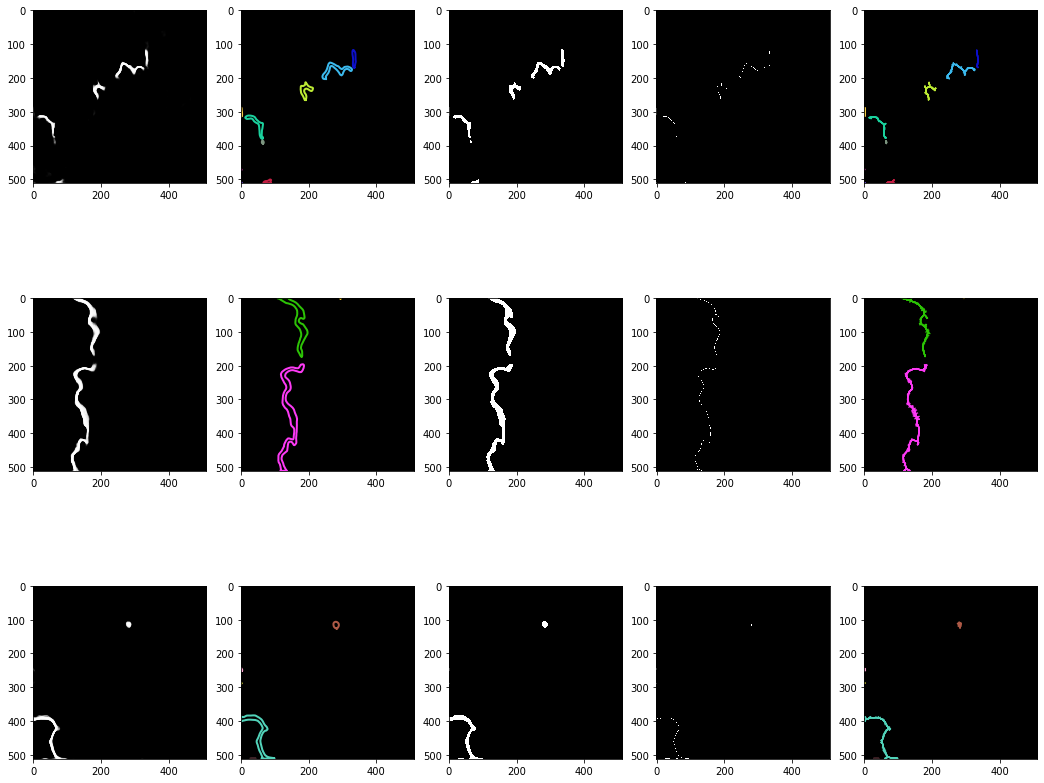

In [57]:
fig,ax = plt.subplots(3,5,figsize=(18,15))
eps = 0.3
attributes = {"id": 1, "name": "polygon", "valid": True}
for j,k in enumerate([15,20,30]):
    print(k)
    im = imageio.imread(fileList[k]).astype(float)/255.
    
    #-- close contour ends to make polygons
    im[np.nonzero(im[:,0] > eps),0] = eps
    im[np.nonzero(im[:,-1] > eps),-1] = eps
    im[0,np.nonzero(im[0,:] > eps)] = eps
    im[-1,np.nonzero(im[-1,:] > eps)] = eps

    contours = measure.find_contours(im, eps)
    
    im2 = np.zeros(im.shape, dtype=int)
    ax[j,1].imshow(np.zeros(im.shape),cmap=plt.cm.gray)
    ax[j,4].imshow(np.zeros(im.shape),cmap=plt.cm.gray)
    for n, contour in enumerate(contours):
        col = np.random.rand(3,)
        ax[j,1].plot(contour[:, 1], contour[:, 0], linewidth=2, color=col)
        #-- draw line through contour
        #-- first make image with just 1 contour, and invert weights
        im2[np.round(contour[:, 0]).astype('int'), np.round(contour[:, 1]).astype('int')] = 1
        im2 = ndimage.binary_fill_holes(im2)

        p = Polygon(zip(contour[:, 1], contour[:, 0]))
#         x,y = p.exterior.xy
#         ax[j,4].plot(x,y,linewidth=2)
        centerline = Centerline(p, **attributes)
        for w in range(len(centerline.geoms)):
            x,y = centerline.geoms[w].coords.xy
            ax[j,4].plot(x,y,linewidth=1.2,color=col)
    
    ax[j,0].imshow(im, cmap=plt.cm.gray)
    ax[j,2].imshow(im2, cmap=plt.cm.gray)
    ax[j,3].imshow(thin(im2), cmap=plt.cm.gray)
plt.show()

In [19]:
attributes = {"id": 1, "name": "polygon", "valid": True}
p = Polygon(zip(np.round(contour[:, 0]).astype('int'), np.round(contour[:, 1]).astype('int')))
centerline = Centerline(p, **attributes)
centerline.geoms

In [34]:
x,y = centerline.geoms[0].coords.xy
y

array('d', [110.82552568329791, 111.41976323029994])

In [35]:
len(centerline.geoms)

1808

In [74]:
cs = np.argwhere(im >= 0.5)
kdt = cKDTree(cs)
edges = kdt.query_pairs(1)
ed = np.array(list(edges))

In [81]:
ed[0]

array([3017, 3067])

In [32]:
print(np.max(cc),np.min(cc))

196.57386363636363 0.0


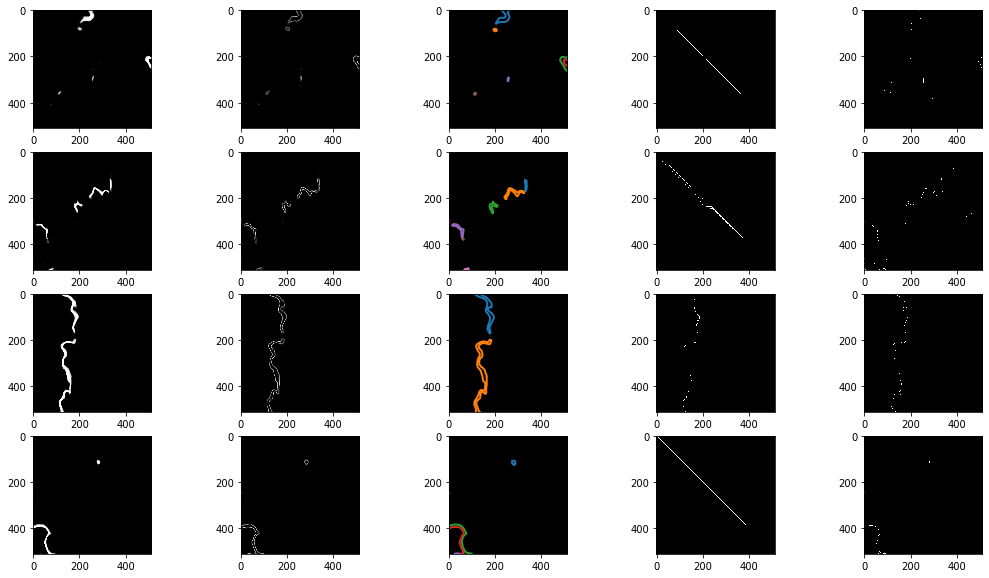

In [92]:
inds = [10,15,20,30]
fig,ax = plt.subplots(4,5,figsize=(18,10))
for j,i in enumerate(inds):
    f = fileList[i]
    im = imageio.imread(f).astype(float)/255.
    edge_sobel = filters.sobel(im)   
    contours = measure.find_contours(im, 0.6)
    ax[j,0].imshow(im, cmap=plt.cm.gray)
    ax[j,1].imshow(edge_sobel, cmap=plt.cm.gray)
    ax[j,2].imshow(np.zeros(im.shape),cmap=plt.cm.gray)
    im_test = np.zeros(im.shape)  
    for n, contour in enumerate(contours):
        ax[j,2].plot(contour[:, 1], contour[:, 0], linewidth=2)
        startPoint = (int(contour[0][-1]),int(contour[1][-1]))
        endPoint = (int(contour[0][0]),int(contour[1][0]))
        testIndices, testWeight = route_through_array(1-im, (startPoint[0], startPoint[1]),
                                                      (endPoint[0], endPoint[1]), geometric=True,fully_connected=True)
        testIndices = np.array(testIndices)
        im_test[testIndices[:,0],testIndices[:,1]] = 1
    ax[j,3].imshow(im_test, cmap=plt.cm.gray)
    ax[j,4].imshow(thin(im), cmap=plt.cm.gray)
plt.show()

In [12]:
ii = np.where(im > 0.98)
print(ii[0][0],ii[1][0])
print(ii[0][-1],ii[1][-1])

1 133
510 135


In [47]:
#-- get route through array
ii = np.where(im > 0.98)
startPoint = (ii[0][-1],ii[1][-1])
endPoint = (ii[0][0],ii[1][0])

testIndices, testWeight = route_through_array(1-im, (startPoint[0], startPoint[1]),
                                              (endPoint[0], endPoint[1]))#, geometric=True,fully_connected=True)

In [48]:
testIndices = np.array(testIndices)
print(testIndices)
print(testIndices.shape)
print(im.size)

[[511 124]
 [510 124]
 [509 124]
 ...
 [  1 119]
 [  1 118]
 [  0 117]]
(583, 2)
262144


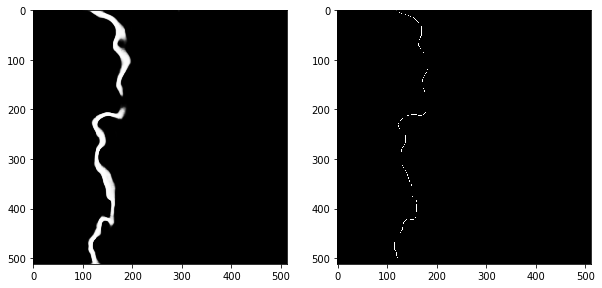

In [49]:
im_test = np.zeros(im.shape)
im_test[testIndices[:,0],testIndices[:,1]] = 1
# im_test[startPoint[0]-20:startPoint[0]+20, startPoint[1]-20:startPoint[1]+20] = 1
# im_test[endPoint[0], endPoint[1]] = 1
fig,ax = plt.subplots(1, 2,figsize=(10,6))
ax[0].imshow(im, cmap=plt.cm.gray)
ax[1].imshow(im_test, cmap=plt.cm.gray)
plt.show()

## Run through all images and save contours

In [9]:
n_test=500
ddir = os.path.expanduser('~/Google Drive File Stream/Shared drives/GROUNDING_LINE_TEAM_DRIVE/ML_Yara/geocoded_v1/')
train_dir = os.path.join(ddir,'train_n%i.dir'%n_test)
test_dir = os.path.join(ddir,'test_n%i.dir'%n_test)

In [10]:
#-- Get list of images
tempfileList = os.listdir(train_dir)
train_list = [f for f in tempfileList if (f.endswith('.npy') and f.startswith('coco'))]
tempfileList = os.listdir(test_dir)
test_list = [f for f in tempfileList if (f.endswith('.npy') and f.startswith('coco'))]

In [60]:
#-- set threshold for getting contours
eps = 0.3
attributes = {"id": 1, "name": "polygon", "valid": True}
#-- get list of PREDICTION file names
file_list_name = [os.path.basename(f) for f in fileList]
#-- Read images and save to file
# for i,f in enumerate(train_list):
for i,f in enumerate(test_list):
    fig,ax = plt.subplots(2,3,figsize=(15,10))
        
    img = np.load(os.path.join(test_dir,f))
    lbl = binary_dilation(np.load(os.path.join(test_dir,f.replace('coco','delineation'))).reshape((im.shape[0],im.shape[1])))

    #-- find corresponding prediction file
    file_ind = file_list_name.index(f.replace('coco','pred').replace('.npy','.png'))
    im = imageio.imread(fileList[file_ind]).astype(float)/255.
    #-- close contour ends to make polygons
    im[np.nonzero(im[:,0] > eps),0] = eps
    im[np.nonzero(im[:,-1] > eps),-1] = eps
    im[0,np.nonzero(im[0,:] > eps)] = eps
    im[-1,np.nonzero(im[-1,:] > eps)] = eps
    #- get contours
    contours = measure.find_contours(im, eps)
    #-- initialize centerline plot
    im2 = np.zeros(im.shape, dtype=int)
    #--------------------------------------------------
    #-- PLOTS
    #--------------------------------------------------
    # plot image
    ax[0,0].imshow(img[:,:,0],cmap='bwr',vmin=-4,vmax=4)
    ax[0,0].set_title('Real')
    ax[0,1].imshow(img[:,:,1],cmap='bwr',vmin=-4,vmax=4)
    ax[0,1].set_title('Imag')
    # plot training label
    ax[0,2].imshow(lbl, cmap=plt.cm.gray)
    ax[0,2].set_title('Label')
    # plot prediction
    ax[1,0].imshow(im, cmap=plt.cm.gray)
    ax[1,0].set_title('Pred')
    # plot contours
    ax[1,1].imshow(np.zeros(im.shape),cmap=plt.cm.gray)
#     ax[1,2].imshow(np.zeros(im.shape),cmap=plt.cm.gray)
    for n, contour in enumerate(contours):
        col = np.random.rand(3,)
        ax[1,1].plot(contour[:, 1], contour[:, 0], linewidth=2, color=col)
        #-- draw line through contour
        im2[np.round(contour[:, 0]).astype('int'), np.round(contour[:, 1]).astype('int')] = 1
        im2 = thin(ndimage.binary_fill_holes(im2))
        
#         p = Polygon(zip(contour[:, 1], contour[:, 0]))
#         centerline = Centerline(p, **attributes)
#         for w in range(len(centerline.geoms)):
#             x,y = centerline.geoms[w].coords.xy
#             ax[1,2].plot(x,y,linewidth=1.2,color=col)
    ax[1,1].set_title('Post')
    ax[1,1].get_xaxis().set_ticks([])
    ax[1,1].get_yaxis().set_ticks([])
    
    ax[1,2].imshow(im2, cmap=plt.cm.gray)
    ax[1,2].set_title('Centerline')
    
    #-- remove plot axes
    for ix in range(2):
        for iy in range(3):
            ax[ix,iy].set_axis_off()
    plt.savefig(os.path.join(out_subdir,f.replace('coco','post').replace('.npy','.png')),format='PNG')
    plt.close()